In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sympy as sp
from sympy.physics.quantum.boson import BosonOp
from sympy.physics.quantum.operator import Operator, Dagger

import sys
sys.path.append('../Packages/PySW/')

from Modules.sympy.classes import *
from Modules.sympy.utils import *

In [3]:

a1 = RDBoson("a_1", subspace ="boson1")
ad1 = RDBoson("{a_1^\\dagger}", subspace ="boson1", is_annihilation=False)
a2 = RDBoson("a_2", subspace ="boson2")
ad2 = RDBoson("{a_2^\\dagger}", subspace ="boson2", is_annihilation=False)

commutation_relations = {
    a1 * ad1 : ad1 * a1 + 1,
    a2 * ad2 : ad2 * a2 + 1,
    a2 * ad1 : ad1 * a2,
    ad2 * a1 : a1 * ad2,
    ad2 * ad1 : ad1 * ad2,
    a2 * a1 : a1 * a2
}


In [4]:
K_p, K_m, k_y, k_B, k_3 = sp.symbols('K_+ K_- k_y k_B k_3', real=True, positive=True)
l_x = sp.symbols('l_x', real=True, positive=True)
L_p = l_x * sp.sqrt(K_p)
L_m = l_x * sp.sqrt(K_m)
phi = sp.symbols('phi', real=True, positive=True)
theta = sp.symbols('theta')#sp.atan(-phi) / 2

sqrt_phi_1 = sp.refine(sp.sqrt(k_y**4 / (k_3**4 * (k_y**2 - 1)**2)), sp.Q.positive(k_y**2 - 1))
phi_val = 2 * k_y**2 / (k_B*sp.sqrt(K_p*K_m*k_y)*(k_y**2 - 1))
phi_val

2*k_y**(3/2)/(sqrt(K_+)*sqrt(K_-)*k_B*(k_y**2 - 1))

In [5]:
x = 1/sp.sqrt(2)*L_p * sp.cos(theta)*(ad1 + a1) + sp.I * L_m/sp.sqrt(2) * sp.sin(theta)*(ad2 - a2)
display(x)
y = 1/sp.sqrt(2)*L_p * sp.sqrt(k_y) * sp.cos(theta)*(ad2 + a2) + sp.I * L_m * sp.sqrt(k_y)/sp.sqrt(2) * sp.sin(theta)*(ad1 - a1)
display(y)

sqrt(2)*sqrt(K_+)*l_x*cos(theta)*(a_1 + {a_1^\dagger})/2 + sqrt(2)*I*sqrt(K_-)*l_x*sin(theta)*(-a_2 + {a_2^\dagger})/2

sqrt(2)*sqrt(K_+)*sqrt(k_y)*l_x*cos(theta)*(a_2 + {a_2^\dagger})/2 + sqrt(2)*I*sqrt(K_-)*sqrt(k_y)*l_x*sin(theta)*(-a_1 + {a_1^\dagger})/2

In [6]:
x_2 = apply_commutation_relations(x**2, commutation_relations)
y_2 = apply_commutation_relations(y**2, commutation_relations)
xy = apply_commutation_relations(x*y, commutation_relations)
yx = apply_commutation_relations(y*x, commutation_relations)

In [31]:
x2_y2_2xy = apply_commutation_relations((x_2 + y_2), commutation_relations).trigsimp().expand().simplify()

x2_y2_2xy_dict = group_by_list_operators(x2_y2_2xy, [a1, ad1, a2, ad2])


In [8]:
K = lambda k: 2*k/(k**2 + 1)

Omega_3_2_f = lambda ky, kB: np.sqrt((1 - 1/ky**2)**2 + 2/kB**2 * (1 + 1/ky**2) + 1/kB**4)
k_p_val = lambda ky, kB: 1/(np.sqrt(1/2) * np.sqrt(1 + 1/ky**2 + 1/kB**2 + Omega_3_2_f(ky, kB)))
k_m_val= lambda ky, kB: 1/(np.sqrt(1/2) * np.sqrt(1 + 1/ky**2 + 1/kB**2 - Omega_3_2_f(ky, kB)))

phi_val = lambda ky, kB: 2*ky**2/(kB*np.sqrt(K(k_p_val(ky, kB)) * K(k_m_val(ky, kB)) * ky)*(ky**2 - 1))
theta_val = lambda ky, kB: np.arctan(-phi_val(ky, kB))/2

In [9]:
first_term = sp.lambdify([k_y, K_m, K_p, theta], (sp.factor_terms(list(x2_y2_2xy_dict.values())[0]) / l_x**2), "numpy")

C:\Users\reascoir\AppData\Local\Temp\ipykernel_24020\3639674827.py:7: RuntimeWarning: divide by zero encountered in divide
  phi_val = lambda ky, kB: 2*ky**2/(kB*np.sqrt(K(k_p_val(ky, kB)) * K(k_m_val(ky, kB)) * ky)*(ky**2 - 1))
<lambdifygenerated-1>:2: RuntimeWarning: invalid value encountered in sin
  return -1/2*1j*sqrt(Dummy_380)*sqrt(Dummy_381)*sqrt(k_y)*sin(2*theta) - 1/2*Dummy_380*k_y*sin(theta)**2 + (1/2)*Dummy_381*cos(theta)**2
<lambdifygenerated-1>:2: RuntimeWarning: invalid value encountered in cos
  return -1/2*1j*sqrt(Dummy_380)*sqrt(Dummy_381)*sqrt(k_y)*sin(2*theta) - 1/2*Dummy_380*k_y*sin(theta)**2 + (1/2)*Dummy_381*cos(theta)**2


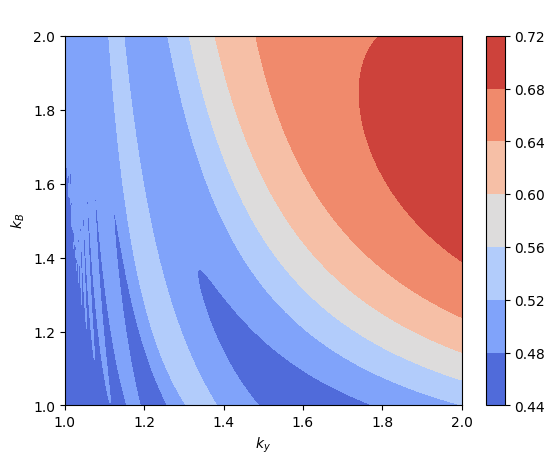

In [10]:
import matplotlib.pyplot as plt


fig, ax = plt.subplots()
KYs = np.linspace(1, 2, 1000)
KBs = np.linspace(1, 2, 1000)
KYS, KBS = np.meshgrid(KYs, KBs)

kps = k_p_val(KYS, KBS)
kms = k_m_val(KYS, KBS)
Kp = K(kps)
Km = K(kms)

theta = phi_val(KYS, KBS)

ft = first_term(KYS, Km, Kp, theta)


# set the (0, 0) element in the bottom left corner
im = ax.contourf(KYS, KBS, np.abs(ft), cmap='coolwarm')
# 
ax.set_title(r'$\Omega_3^2 / \omega_x^2$', color='white')
ax.set_xlabel(r'$k_y$')
ax.set_ylabel(r'$k_B$')

#ax.set_xscale('log')
#ax.set_yscale('log')


#color bar log scale
cbar = fig.colorbar(im)


In [32]:
display_dict(x2_y2_2xy_dict)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

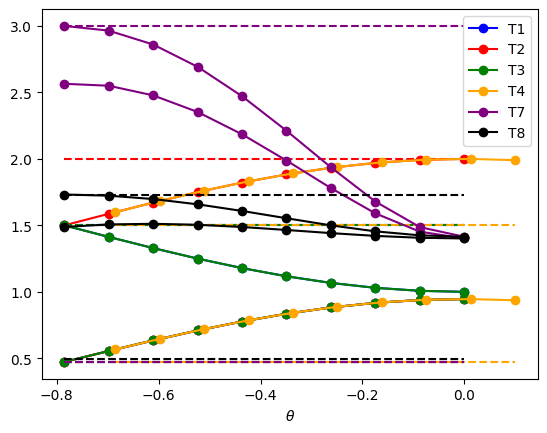

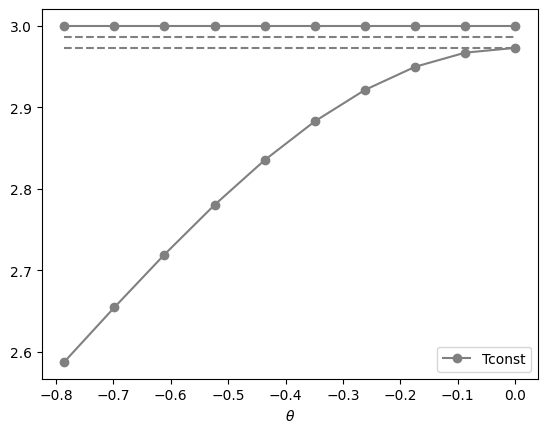

In [12]:
varphi = (1 + np.sqrt(5)) / 2

Kp_min = np.sqrt(1 / (varphi - 1/2))
Km_min = 0
Ky_min = 1

Kp_max = 1
Ky_max = 2

Km_max = 1

def plot_Ti(Ti, theta, timin, timax, ax, color='blue', label='Ti', marker='o'):
    ax.plot(theta, Ti(Kp_min, Km_min, Ky_min, theta), color=color, label=label, marker=marker)
    ax.plot(theta, Ti(Kp_max, Km_max, Ky_max, theta), color=color, marker=marker)
    ax.hlines(timin, theta.min(), theta.max(), color=color, linestyle='--')
    ax.hlines(timax, theta.min(), theta.max(), color=color, linestyle='--')
    ax.set_xlabel(r'$\theta$')
    ax.legend()
    return ax


T1 = lambda kp, km, ky, t: kp * np.cos(t)**2 + km * ky * np.sin(t)**2
t1min_full = 0  # theta in [0, 2pi]
t1max_full = Ky_max
t1min = Kp_min/2
t1max = (1+Ky_max)/2

theta = np.linspace(-np.pi/4, 0, 10)
#theta = np.linspace(-2*np.pi, 0, 100)

fig, ax = plt.subplots()
ax= plot_Ti(T1, theta, t1min, t1max, ax, color='blue', label='T1')


T2 = lambda kp, km, ky, t: kp * ky * np.cos(t)**2 + km * np.sin(t)**2
t2min_full = 0
t2max_full = Ky_max
t2min = Kp_min/2
t2max = Ky_max

#theta = np.linspace(-np.pi/4, 0, 11)
#theta = np.linspace(-2*np.pi, 0, 1000)

#fig, ax = plt.subplots()
ax= plot_Ti(T2, theta, t2min, t2max, ax, color='red', label='T2')

T3 = lambda kp, km, ky, t: np.abs(kp * np.cos(t)**2 - km * ky * np.sin(t)**2 - 1j * np.sqrt(kp*km*ky) * np.sin(2*t))
t3min_full = 0
t3max_full = Ky_max
t3min = Kp_min/2
t3max = (1+Ky_max)/2


ax = plot_Ti(T3, theta, t3min, t3max, ax, color='green', label='T3')

T4 = lambda kp, km, ky, t: np.abs(kp * ky * np.cos(t)**2 - km * np.sin(t)**2 - 1j * np.sqrt(kp*km*ky) * np.sin(2*t))
t3min_full = 0
t3max_full = Ky_max
t3min = Kp_min/2
t3max = (1+Ky_max)/2


ax = plot_Ti(T4, theta+0.1, t3min, t3max, ax, color='orange', label='T4')

T7 = lambda kp, km, ky, t: np.abs(kp * np.sqrt(ky) * np.cos(t)**2 -km*np.sqrt(ky) * np.sin(t)**2 - 1j * np.sqrt(kp*km) * (1 + ky) * np.sin(2*t))
t7min = Kp_min/2
t7max = (1+Ky_max)

Ky_min = 2
Kb = 2
kp = k_p_val(Ky_min, Kb)
km = k_m_val(Ky_min, Kb)
Kp_min = K(kp)
Km_min = K(km)

ax = plot_Ti(T7, theta, t7min, t7max, ax, color='purple', label='T7')

T8 = lambda kp, km, ky, t: np.abs(kp * np.sqrt(ky) * np.cos(t)**2 + km*np.sqrt(ky) * np.sin(t)**2 - 1j * np.sqrt(kp*km) * (ky-1) * np.sin(2*t))
t8min = Kp_min/2
t8max = np.sqrt(Ky_max**2 - Ky_max + 1)


ax = plot_Ti(T8, theta, t8min, t8max, ax, color='black', label='T8')


Tconst = lambda kp, km, ky, t: (1+ky)*(kp * np.cos(t)**2 + km * np.sin(t)**2)
Ky_min = 2
Kb = 2
kp = k_p_val(Ky_min, Kb)
km = k_m_val(Ky_min, Kb)
Kp_min = K(kp)
Km_min = K(km)

fig, ax = plt.subplots()
ax = plot_Ti(Tconst, theta, (Kp_min + Kp_max) / 2 * (1 + Ky_min), (Ky_min + 1) * Kp_min, ax, color='gray', label='Tconst')

1.7995857194729337 2.8460498941515415
1.7995500148239227 1.8035381512024147


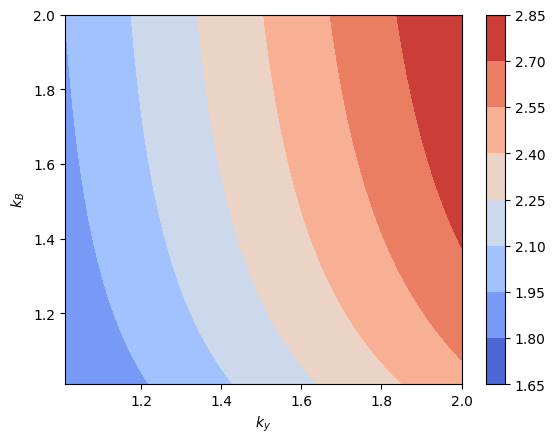

In [13]:
import matplotlib.pyplot as plt


fig, ax = plt.subplots()
KYs = np.linspace(1.01, 2, 1000)
KBs = np.linspace(1.01, 2, 1000)
KYS, KBS = np.meshgrid(KYs, KBs)

kps = k_p_val(KYS, KBS)
kms = k_m_val(KYS, KBS)
Kp = K(kps)
Km = K(kms)

theta = theta_val(KYS, KBS)

A = Kp * np.sqrt(KYS)
B = Km * np.sqrt(KYS)
C = np.sqrt(Kp*Km) * (KYS - 1)
Tis = Tconst(Kp, Km, KYS, theta)

print(Tis[0,0], Tis.max())
#print(Kp[0,0], (Kp[-1,-1] + Km[-1,-1]*KYs.max())/2)
#print(1/2,  Kp[-1,-1]*KYs.max())
#print(Kp.min(), (Kp[-1,-1] + Km[-1,-1]*KYs.max())/2)

ky = 1.01#KYs[-1]
Kb = 1.01#KBS[Tis == Tis.max()][0]
Kp = K(k_p_val(ky, Kb))
Km = K(k_m_val(ky, Kb))
#print(ky, Kb)
#print(Kp * np.sqrt(ky), np.sqrt(4*C**2 * (A*B+C**2) / (4*C**2 - (A-B)**2)).max())
print((1+ky) * (Kp + Km)/2, Kp * (1+ky))




# set the (0, 0) element in the bottom left corner
im = ax.contourf(KYS, KBS, Tis, cmap='coolwarm')
# 
ax.set_xlabel(r'$k_y$')
ax.set_ylabel(r'$k_B$')

#ax.set_xscale('log')
#ax.set_yscale('log')

#color bar log scale
cbar = fig.colorbar(im)


In [14]:
ky = 2
kB = 2
Kp = K(k_p_val(ky, kB))
Km = K(k_m_val(ky, kB))
T1(Kp, Km, ky, theta_val(ky, kB)), (Kp + Km * ky)/2

(1.069471556482497, 1.2293766081428326)

In [15]:
Kp.max()

0.9910042311707484

In [16]:
theta = sp.symbols('theta', real=True)
A, B, C = sp.symbols('A B C', real=True, positive=True)
C = 0
z = A * sp.cos(theta)**2 + B * sp.sin(theta)**2 + sp.I * C* sp.sin(2*theta)
display(z)
z_abs = sp.factor_terms(sp.expand_trig(z*z.adjoint()).expand().simplify().cancel().subs({sp.sin(theta)**4: (1 - sp.cos(theta)**2)**2}).expand()).trigsimp()
display(sp.trigsimp(sp.sqrt(z_abs)))
thetas_derivative_0 = sp.solve(sp.diff(z_abs, theta).simplify(), theta)
display(sp.diff(z_abs, theta).simplify())

A*cos(theta)**2 + B*sin(theta)**2

Abs(-A*sin(theta)**2 + A + B*sin(theta)**2)

4*(-A + B)*(-A*sin(theta)**2 + A + B*sin(theta)**2)*sin(theta)*cos(theta)

In [17]:
abs_z =lambda t: sp.expand_trig(sp.Abs(z)**2).expand().subs({theta: t}).cancel().factor()

res = []
for t in thetas_derivative_0:
    display_dict({t: abs_z(t)})
    res.append(abs_z(t))

print('Unique values')
res_unique = list(set(res))
for r in res_unique:
    display(r)
    

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Unique values


A**2

0

B**2

In [18]:
display(z)
sp.N(sp.diff(sp.Abs(z)**2, theta, 1).subs({theta: -sp.pi/4})).factor()

A*cos(theta)**2 + B*sin(theta)**2

1.0*(A - B)*(A + B)

In [19]:
(sp.Abs(z)**2).subs({theta: -sp.pi/4}).factor()

(A + B)**2/4

In [20]:
1-0.004 - 0.996 + 2*0.008

0.016

In [21]:
sp.factor_terms(t.factor().simplify())

asin(sqrt(A)*sqrt(1/(A - B)))

In [22]:
z = A * sp.cos(theta)**2 - B * sp.sin(theta)**2 - sp.I * sp.sqrt(A*B) * sp.sin(2*theta)
sp.expand_trig((sp.im(z)/sp.re(z))).subs({sp.sin(theta)**2: 1 - sp.cos(theta)**2}).cancel()

-2*sqrt(A)*sqrt(B)*sin(theta)*cos(theta)/(A*cos(theta)**2 + B*cos(theta)**2 - B)

# Plot Upper Bounds

In [23]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np

plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=18)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=16)    # fontsize of the tick labels
plt.rc('ytick', labelsize=16)    # fontsize of the tick labels
plt.rc('legend', fontsize=16)    # legend fontsize

# Transparent background for figures but keep the legend background white but its text color black
plt.rcParams['legend.facecolor'] = 'white'
plt.rcParams['legend.edgecolor'] = 'none'
plt.rcParams['legend.framealpha'] = 0.8
plt.rcParams['legend.shadow'] = False
plt.rcParams['figure.facecolor'] = 'none'
plt.rcParams['axes.facecolor'] = 'none'
# White spins, axis and ticks 
plt.rcParams['text.color'] = 'black'
plt.rcParams['axes.labelcolor'] = 'white'
plt.rcParams['xtick.color'] = 'white'
plt.rcParams['ytick.color'] = 'white'
plt.rcParams['axes.labelcolor'] = 'white'
plt.rcParams['axes.edgecolor'] = 'white'

In [24]:
K = lambda k: 2*k/(k**2 + 1)
Omega_3_2_f = lambda ky, kB: np.sqrt((1 - 1/ky**2)**2 + 2/kB**2 * (1 + 1/ky**2) + 1/kB**4)

k_p_val = lambda ky, kB: 1/(np.sqrt(1/2) * np.sqrt(1 + 1/ky**2 + 1/kB**2 + Omega_3_2_f(ky, kB)))
k_m_val= lambda ky, kB: 1/(np.sqrt(1/2) * np.sqrt(1 + 1/ky**2 + 1/kB**2 - Omega_3_2_f(ky, kB)))

phi_val = lambda ky, kB: 2*ky**2/(kB*np.sqrt(K(k_p_val(ky, kB)) * K(k_m_val(ky, kB)) * ky)*(ky**2 - 1))
theta_val = lambda ky, kB: np.arctan(-phi_val(ky, kB))/2


In [25]:
T1 = lambda Kp, Km, ky, t: Kp * np.cos(t)**2 + Km * ky * np.sin(t)**2
T2 = lambda Kp, Km, ky, t: Kp * ky * np.cos(t)**2 + Km * np.sin(t)**2
T1_2 = lambda Kp, Km, ky, t: T1(Kp, Km, ky, t) / 2
T2_2 = lambda Kp, Km, ky, t: T2(Kp, Km, ky, t) / 2

T_const = lambda Kp, Km, ky, t: (1+ky)*(Kp * np.cos(t)**2 + Km * np.sin(t)**2) / 2
T_1 = lambda Kp, Km, ky, t: np.abs(Kp * np.sqrt(ky) * np.cos(t)**2 - Km*np.sqrt(ky) * np.sin(t)**2 - 1j * np.sqrt(Kp*Km) * (1 + ky) * np.sin(2*t)) / 2
T_2 = lambda Kp, Km, ky, t: np.abs(Kp * np.sqrt(ky) * np.cos(t)**2 + Km*np.sqrt(ky) * np.sin(t)**2 - 1j * np.sqrt(Kp*Km) * (ky - 1) * np.sin(2*t)) / 2

Ts = [T1, T2, T1_2, T2_2, T_const, T_1, T_2]
titles = ['$T_1$', '$T_2$', '$T_1/2$' , '$T_2/2$' , r'$T_{const}/2$', r'$\left|\mathcal{T}_1\right|/2$', r'$\left|\mathcal{T}_2\right|/2$']

In [26]:

fig = plt.figure(figsize=(7 * 3, 6 * 3), constrained_layout=True)

# Define GridSpec with 3 rows and 2 columns
gs = gridspec.GridSpec(3, 3, figure=fig)

ax = []
for i in range(len(Ts)-1):
    row = i // 3
    col = i % 3
    ax.append(fig.add_subplot(gs[row, col]))

ax.append(fig.add_subplot(gs[2, 1]))

kys = np.linspace(1, 2, 1000)
kbs = np.linspace(1, 2, 1000)
KYS, KBS = np.meshgrid(kys, kbs)

Kp = K(k_p_val(KYS, KBS))
Km = K(k_m_val(KYS, KBS))
theta = theta_val(KYS, KBS)

vmax = np.max([T(Kp, Km, KYS, theta).max() for T in Ts])
vmin = np.min([T(Kp, Km, KYS, theta).min() for T in Ts])

N_levels = 100
levels = np.linspace(vmin, vmax, N_levels)

for i, T in enumerate(Ts):
    Ti = T(Kp, Km, KYS, theta)
    im = ax[i].contourf(KYS, KBS, Ti, cmap='coolwarm', vmin=vmin, vmax=vmax, levels=levels)
    ax[i].set_xlabel(r'$k_y$', fontsize=18, color='white')
    ax[i].set_ylabel(r'$k_B$', fontsize=18, color='white')
    ax[i].set_title(titles[i], fontsize=18, color='white', pad=10)

# Add a colorbar for each row
#for i in range(2):
    #cbar = fig.colorbar(im, ax=ax[i * 2:i * 2 + 2], orientation='vertical')
fig.colorbar(im, ax=ax, orientation='vertical', pad=0.1, aspect=40)


plt.show()


C:\Users\reascoir\AppData\Local\Temp\ipykernel_24020\2837813642.py:7: RuntimeWarning: divide by zero encountered in divide
  phi_val = lambda ky, kB: 2*ky**2/(kB*np.sqrt(K(k_p_val(ky, kB)) * K(k_m_val(ky, kB)) * ky)*(ky**2 - 1))


RuntimeError: Failed to process string with tex because latex could not be found

<Figure size 2100x1800 with 8 Axes>

In [27]:
T1_max = lambda Kp, Km, ky, t: (Kp + Km * ky)/2
T2_max = lambda Kp, Km, ky, t: Kp * ky
T1_max_2 = lambda Kp, Km, ky, t: T1_max(Kp, Km, ky, t) / 2
T2_max_2 = lambda Kp, Km, ky, t: T2_max(Kp, Km, ky, t) / 2

T_const_max = lambda Kp, Km, ky, t: Kp * (1 + ky) /2
T_1_max = lambda Kp, Km, ky, t: 1/2 * np.sqrt(ky * (Kp - Km)**2 + 4*Kp*Km*(1 + ky)**2) / 2
T_2_max = lambda Kp, Km, ky, t: np.sqrt((4*Kp**2*Km**2*(ky - 1)**2*(ky**2 - ky + 1)) / (4*Kp*Km*(ky - 1)**2 - ky*(Kp - Km)**2)) / 2

Ts_max = [T1_max, T2_max, T1_max_2, T2_max_2, T_const_max, T_1_max, T_2_max]

In [28]:

fig = plt.figure(figsize=(7 * 3, 6 * 3), constrained_layout=True)

# Define GridSpec with 3 rows and 2 columns
gs = gridspec.GridSpec(3, 3, figure=fig)

ax = []
for i in range(len(Ts)-1):
    row = i // 3
    col = i % 3
    ax.append(fig.add_subplot(gs[row, col]))

ax.append(fig.add_subplot(gs[2, 1]))

kys = np.linspace(1.01, 2, 1000)
kbs = np.linspace(1.01, 2, 1000)
KYS, KBS = np.meshgrid(kys, kbs)

Kp = K(k_p_val(KYS, KBS))
Km = K(k_m_val(KYS, KBS))
theta = theta_val(KYS, KBS)

vmax = np.max([Ts_max[i](Kp, Km, KYS, theta) - Ts[i](Kp, Km, KYS, theta) for i in range(len(Ts))])
vmin = np.min([Ts_max[i](Kp, Km, KYS, theta) - Ts[i](Kp, Km, KYS, theta) for i in range(len(Ts))])

N_levels = 100
levels = np.linspace(vmin, vmax, N_levels)

for i, T in enumerate(Ts):
    Ti = T(Kp, Km, KYS, theta)
    Ti_max = Ts_max[i](Kp, Km, KYS, theta)
    delta_ti = Ti_max - Ti
    print(delta_ti.min(), delta_ti.max())
    im = ax[i].contourf(KYS, KBS, delta_ti, cmap='coolwarm', vmin=vmin, vmax=vmax, levels=levels)
    ax[i].set_xlabel(r'$k_y$', fontsize=18, color='white')
    ax[i].set_ylabel(r'$k_B$', fontsize=18, color='white')
    ax[i].set_title(titles[i], fontsize=18, color='white', pad=10)

# Add a colorbar for each row
#for i in range(2):
    #cbar = fig.colorbar(im, ax=ax[i * 2:i * 2 + 2], orientation='vertical')
fig.colorbar(im, ax=ax, orientation='vertical', pad=0.1, aspect=40)


plt.show()


2.2224438421925008e-05 0.15990505166033553
0.005915208048953624 0.39070526465726974
1.1112219210962504e-05 0.07995252583016776
0.002957604024476812 0.19535263232863487
0.0011591416567734436 0.14910263287264636
2.258163699342397e-05 0.21005001412962865
1.5543122344752192e-15 0.014309097308887964


RuntimeError: Failed to process string with tex because latex could not be found

<Figure size 2100x1800 with 8 Axes>

In [29]:


kys = np.linspace(1.01, 2, 1000)
kbs = np.linspace(1.01, 2, 1000)
KYS, KBS = np.meshgrid(kys, kbs)

Kp = K(k_p_val(KYS, KBS))
Km = K(k_m_val(KYS, KBS))
theta = theta_val(KYS, KBS)

heat_map = np.zeros((len(Ts_max), len(Ts_max)))

for i, T in enumerate(Ts_max):
    Ti = T(Kp, Km, KYS, theta)
    for j, T_prime in enumerate(Ts_max):
        Ti_prime = T_prime(Kp, Km, KYS, theta)
        delta_ti = Ti / Ti_prime
        heat_map[i, j] = delta_ti.min()


In [30]:
ky = 1
kB = np.linspace(1, 2)
Kp = K(k_p_val(ky, kB))
Km = K(k_m_val(ky, kB))

fig, ax = plt.subplots(figsize=(7, 6))

ax.plot(kB, Kp)
ax.plot(kB, Km)


Error in callback <function _draw_all_if_interactive at 0x0000028E74F8CEA0> (for post_execute), with arguments args (),kwargs {}:



KeyboardInterrupt



RuntimeError: Failed to process string with tex because latex could not be found

<Figure size 700x600 with 1 Axes>

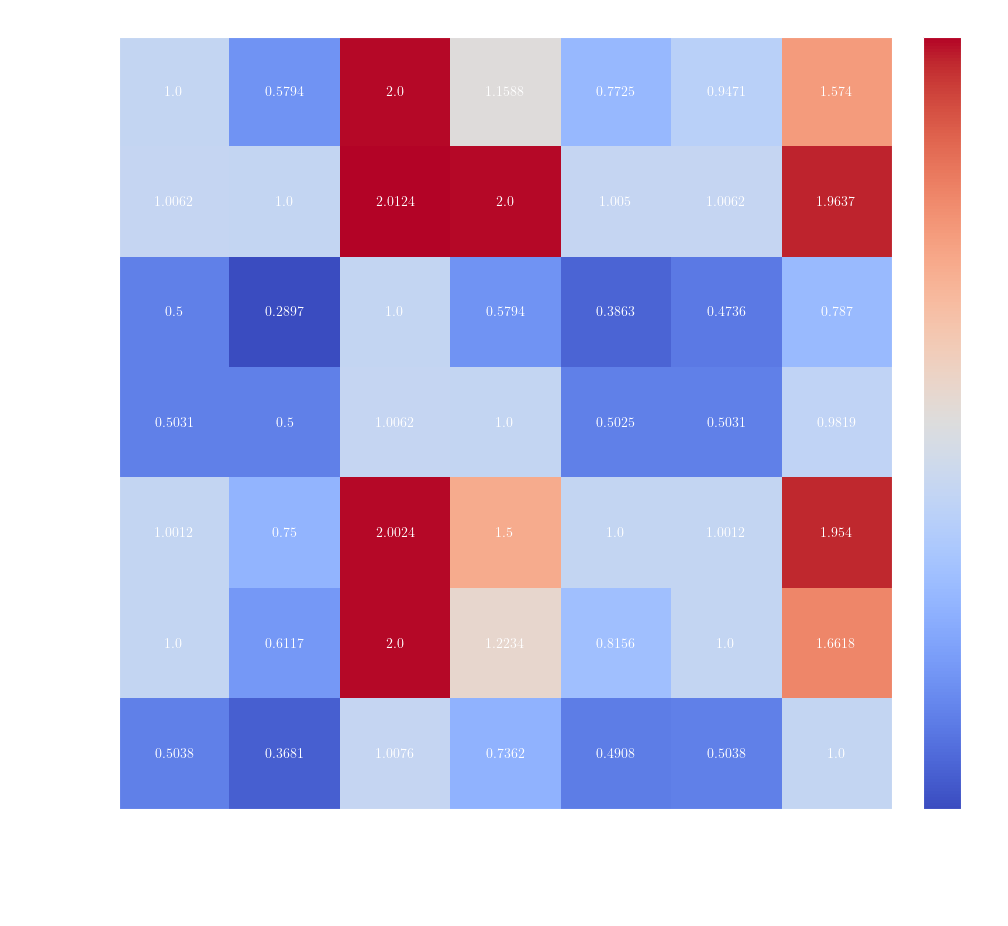

In [81]:

fig, ax = plt.subplots(figsize=(10, 10), constrained_layout=True)

im = ax.imshow(heat_map, cmap='coolwarm')

ax.set_xticks(np.arange(len(Ts)))
ax.set_yticks(np.arange(len(Ts)))
# ... and label them with the respective list entries
ax.set_xticklabels(titles)
ax.set_yticklabels(titles)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(Ts)):
    for j in range(len(Ts)):
        text = ax.text(j, i, heat_map[i, j].round(4),
                       ha="center", va="center", color="w")

# set the height of the colorbar to be 40% of the axes' height
plt.colorbar(im, ax=ax, fraction=0.05, pad=0.04)
ax.set_title("Heatmap of $T_i/T_i'$", fontsize=18, color='white')
ax.set_ylabel('$T_i$', fontsize=18, color='white')
ax.set_xlabel("$T_i'$", fontsize=18, color='white')
plt.show()

In [82]:
ky = 1.01
kB = 1.14
Kp = K(k_p_val(ky, kB))
Km = K(k_m_val(ky, kB))

Kp * ky * 60

55.56229247011137

In [83]:
Ti_res = []
for i, T in enumerate(Ts):
    Ti = T(Kp, Km, ky, theta_val(ky, kB))
    Ti_res.append(Ti)

index_sorted = np.argsort(Ti_res)
for i in index_sorted:
    print(titles[i], Ti_res[i]*60*np.sqrt(2))

$T_1/2$ 39.01409522903055
$\left|\mathcal{T}_2\right|/2$ 39.01793771356199
$T_2/2$ 39.01888364717156
$T_1$ 78.0281904580611
$\left|\mathcal{T}_1\right|/2$ 78.02852697719966
$T_{const}/2$ 78.03297887620211
$T_2$ 78.03776729434313


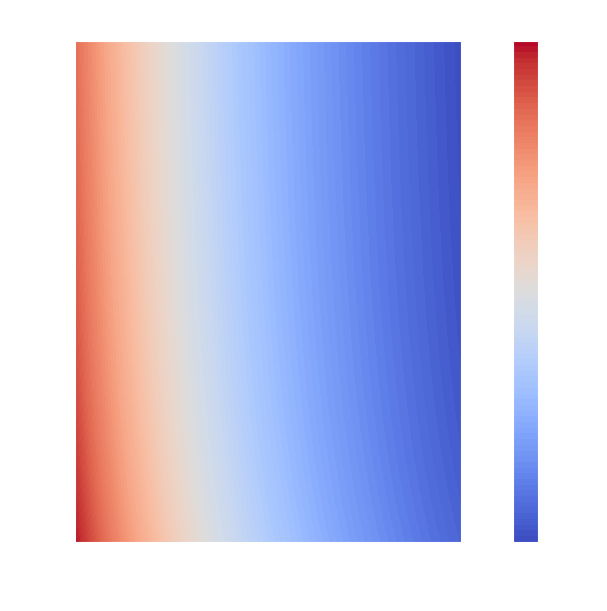

In [84]:
kys = np.linspace(1.0001, 2, 1000)
kbs = np.linspace(1.0001, 2, 1000)
KYS, KBS = np.meshgrid(kys, kbs)

Kp = K(k_p_val(KYS, KBS))
Km = K(k_m_val(KYS, KBS))
theta = theta_val(KYS, KBS)

lx = 60

fig, ax = plt.subplots(figsize=(6, 6), constrained_layout=True)

im = ax.contourf(KYS, KBS, np.sqrt(1/2)*1/(KYS*Kp), cmap='coolwarm', levels=100)

ax.set_xlabel(r'$k_y$', fontsize=18, color='white')
ax.set_ylabel(r'$k_B$', fontsize=18, color='white')
ax.set_title(r'$T_2$', fontsize=18, color='white', pad=10)

fig.colorbar(im, ax=ax, orientation='vertical', pad=0.1)

In [85]:
(2*varphi - 1) / (2*np.sqrt(2))

0.7905694150420948

In [86]:
from scipy.optimize import fsolve

def found_zeros(f, x0, x1, tol=1e-12, N=100):
    x = np.linspace(x0, x1, N)
    y = f(x)
    y_pos = (y > 0)*1
    y_diff = np.where((np.abs(np.diff(y_pos)) + np.roll(np.abs(np.diff(y_pos)), 1)) > 0)[0]
    x_z = x[y_diff]
    x_zeros = []
    for x_zero in x_z:
        res = fsolve(f, x_zero, xtol=tol)
        if np.any(np.isclose(res, x_zeros, atol=tol)):
            continue
        x_zeros.append(res)  
    x_zeros = np.array(x_zeros).flatten()
    return x_zeros

In [87]:
from Simulation_utils import CylindricalMagnet, Hamiltonian2D_Elliptical_Quantum_Well
import json
simulation_params = json.load(open('simulation_params.json', 'r'))
display_dict(simulation_params)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [116]:
lx = 60

M = simulation_params['M']
L = simulation_params['L'] / lx
Delta_z = simulation_params['Delta z']
R0 = 50
skyrmion = CylindricalMagnet(M, R0, L, Delta_z)

In [117]:
R = np.linspace(10/lx, 50/lx, 100)
Delta_z = np.linspace(0.5, 3, 100)

R_mesh, Delta_z_mesh = np.meshgrid(R, Delta_z)

B = simulation_params['Bz'] + skyrmion.b_0(R=R_mesh, z=Delta_z_mesh)
B1 = skyrmion.b_1(R=R_mesh, z=Delta_z_mesh)
B2 = skyrmion.b_2(R=R_mesh, z=Delta_z_mesh)

C:\Users\reascoir\AppData\Local\Temp\ipykernel_3376\1340877976.py:11: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  res = fsolve(f, x_zero, xtol=tol)


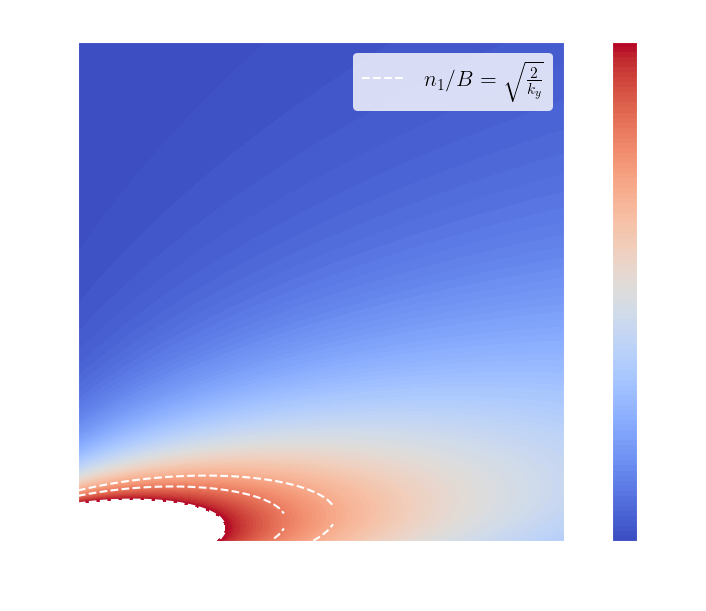

In [118]:

fig, ax = plt.subplots(figsize=(7, 6), constrained_layout=True)

Kys = [1, 1.5, 2]

for i, ky in enumerate(Kys):
    line_less_equal_sqrt2 = []
    for r in R:
        res =  found_zeros(lambda z: skyrmion.b_1(R=r, z=z)/(simulation_params['Bz'] + skyrmion.b_0(R=r, z=z)) - np.sqrt(2/ky), 0.5, 3, N=1000, tol=1e-12)
        if len(res) == 1:
            line_less_equal_sqrt2.append([np.nan, res[0]])
        elif len(res) == 2:
            line_less_equal_sqrt2.append([res[0], res[1]])
        else:
            line_less_equal_sqrt2.append([np.nan, np.nan])

    line_less_equal_sqrt2 = np.array(line_less_equal_sqrt2)

    if ky == 1:
        ax.plot(R, line_less_equal_sqrt2[:,0], linestyle='--', label=r'$n_1/B = \sqrt{\frac{2}{k_y}}$', color='white')
        ax.plot(R, line_less_equal_sqrt2[:,1], linestyle='--', color='white')
    else:
        ax.plot(R, line_less_equal_sqrt2[:,0], linestyle='--', color='white')
        ax.plot(R, line_less_equal_sqrt2[:,1], linestyle='--', color='white')





vmin = np.min(B1 / B)
vmax = np.sqrt(2)
N_levels = 100
levels = np.linspace(vmin, vmax, N_levels)

im = ax.contourf(R_mesh, Delta_z_mesh, B1 / B, cmap='coolwarm', levels=levels, vmax=np.sqrt(2), vmin=vmin)

ax.set_xlabel(r'$R/l_x$', fontsize=18, color='white')
ax.set_ylabel(r'$\Delta z/l_x$', fontsize=18, color='white')
ax.set_title(r'$n_1/B$', fontsize=18, color='white', pad=10)

fig.colorbar(im, ax=ax, orientation='vertical', pad=0.1)
ax.legend()

C:\Users\reascoir\AppData\Local\Temp\ipykernel_3376\1340877976.py:11: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  res = fsolve(f, x_zero, xtol=tol)


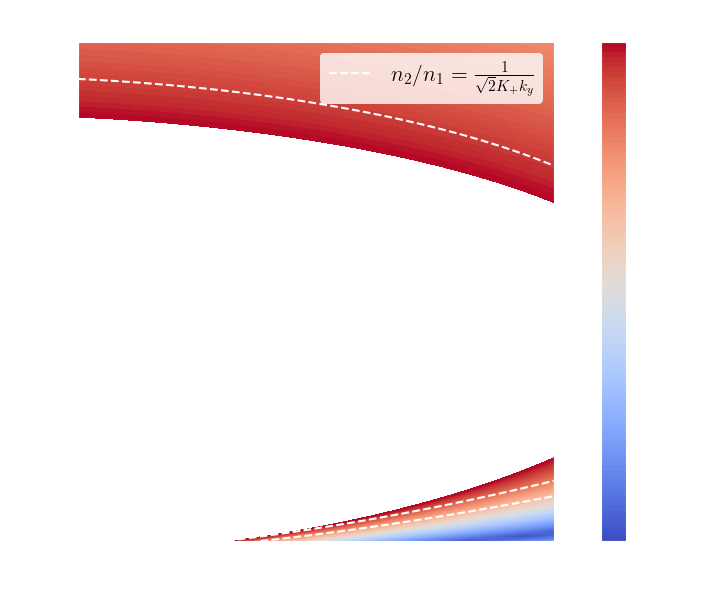

In [125]:
from Simulation_utils import h_bar, e, NM, m, gamma

fig, ax = plt.subplots(figsize=(7, 6), constrained_layout=True)

omega_x = h_bar / (m * NM**2 * lx**2)

Kys = [1, 1.5, 2]
for i, ky in enumerate(Kys):
    line_less_equal_sqrt2 = []
    for r in R:
        kb = lambda z: m * omega_x / (e * (skyrmion.b_0(R=r * lx * NM, z=z*lx*NM, L=simulation_params['L']*NM) + simulation_params['Bz']))
        Kp = lambda z: K(k_p_val(ky, kb(z)))
        res =  found_zeros(lambda z: skyrmion.b_2(R=r, z=z)/skyrmion.b_1(R=r, z=z) - 1/(np.sqrt(2)*Kp(z)*ky), 0.5, Delta_z.max(), N=1000, tol=1e-12)
        if len(res) == 1:
            line_less_equal_sqrt2.append([np.nan, res[0]])
        elif len(res) == 2:
            line_less_equal_sqrt2.append([res[0], res[1]])
        else:
            line_less_equal_sqrt2.append([np.nan, np.nan])

    line_less_equal_sqrt2 = np.array(line_less_equal_sqrt2)

    if ky == 1:
        ax.plot(R, line_less_equal_sqrt2[:,0], linestyle='--', label=r'$n_2/n_1 = \frac{1}{\sqrt{2}K_+ k_y}$', color='white')
        ax.plot(R, line_less_equal_sqrt2[:,1], linestyle='--', color='white')
    else:
        ax.plot(R, line_less_equal_sqrt2[:,0], linestyle='--', color='white')
        ax.plot(R, line_less_equal_sqrt2[:,1], linestyle='--', color='white')

vmax =  (2*varphi - 1)/(2*np.sqrt(2))
vmin = 0
N_levels = 100

levels = np.linspace(vmin, vmax, N_levels)


im = ax.contourf(R_mesh, Delta_z_mesh, B2 / B1, cmap='coolwarm', levels=levels, vmax=vmax, vmin=vmin)


ax.set_xlabel(r'$R/l_x$', fontsize=18, color='white')
ax.set_ylabel(r'$\Delta z/l_x$', fontsize=18, color='white')
ax.set_title(r'$n_1/n_2$', fontsize=18, color='white', pad=10)

fig.colorbar(im, ax=ax, orientation='vertical', pad=0.1)

ax.legend()

In [124]:
kb = m * omega_x / (e * (skyrmion.b_0(R=50 * NM, z=0.8*lx*NM, L=simulation_params['L']*NM) + simulation_params['Bz']))

kb

0.5138693575178047

C:\Users\reascoir\AppData\Local\Temp\ipykernel_3376\1340877976.py:11: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  res = fsolve(f, x_zero, xtol=tol)


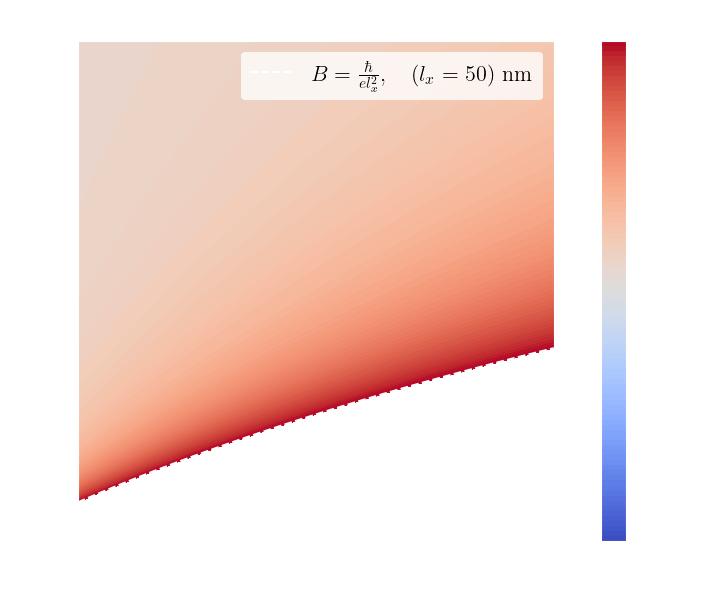

In [93]:


fig, ax = plt.subplots(figsize=(7, 6), constrained_layout=True)

line_less_equal = []
for r in R:
    res =  found_zeros(lambda z: simulation_params['Bz'] + skyrmion.b_0(R=r, z=z) - h_bar/(e*(lx*NM)**2), 0.5, 3, N=1000, tol=1e-12)
    if len(res) == 1:
        line_less_equal.append([np.nan, res[0]])
    elif len(res) == 2:
        line_less_equal.append([res[0], res[1]])
    else:
        line_less_equal.append([np.nan, np.nan])

line_less_equal = np.array(line_less_equal)

ax.plot(R, line_less_equal[:, 0], color='white', linestyle='--', label=r'$B = \frac{\hbar}{el_x^2},\quad (l_x=50)$ nm')
ax.plot(R, line_less_equal[:, 1], color='white', linestyle='--')

vmax = h_bar/(e*(lx*NM)**2)
vmin = 0
N_levels = 100

levels = np.linspace(vmin, vmax, N_levels)

im = ax.contourf(R_mesh, Delta_z_mesh, B, cmap='coolwarm', levels=levels, vmax=vmax, vmin=vmin)



ax.set_xlabel(r'$R/l_x$', fontsize=18, color='white')
ax.set_ylabel(r'$\Delta z/l_x$', fontsize=18, color='white')
ax.set_title(r'$B=B_z + b_0$', fontsize=18, color='white', pad=10)

fig.colorbar(im, ax=ax, orientation='vertical', pad=0.1)

ax.legend()

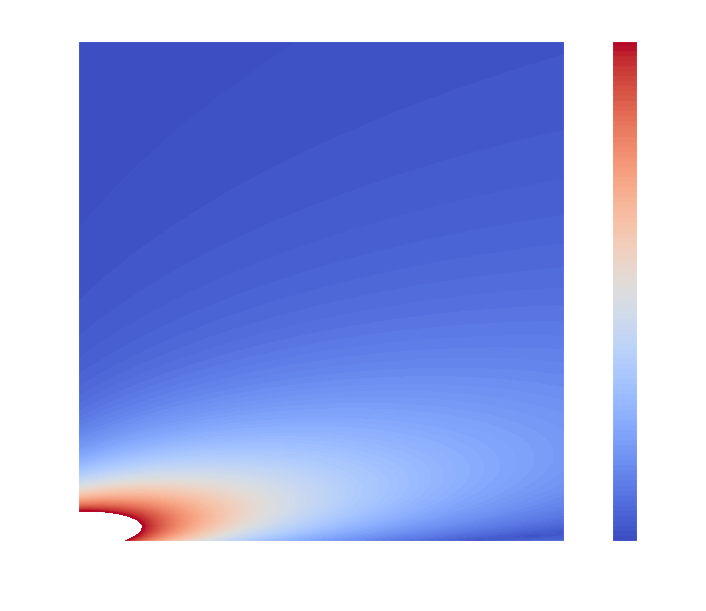

In [136]:
fig, ax = plt.subplots(figsize=(7, 6), constrained_layout=True)


vmax = 1
vmin = 0
N_levels = 100

levels = np.linspace(vmin, vmax, N_levels)

one_kE32 = np.sqrt(2)/2 * B2/B

kb = m * omega_x / (e * (skyrmion.b_0(R=R_mesh * lx * NM, z=Delta_z_mesh*lx*NM, L=simulation_params['L']*NM) + simulation_params['Bz']))
Kp = K(k_p_val(1, kb))
kz = kb / gamma
one_kE32 *= Kp / kz
one_kE32 = one_kE32 ** (2/3)

im = ax.contourf(R_mesh, Delta_z_mesh, one_kE32, cmap='coolwarm', levels=levels, vmax=vmax, vmin=vmin)



ax.set_xlabel(r'$R/l_x$', fontsize=18, color='white')
ax.set_ylabel(r'$\Delta z/l_x$', fontsize=18, color='white')
ax.set_title(r'$B=B_z + b_0$', fontsize=18, color='white', pad=10)

fig.colorbar(im, ax=ax, orientation='vertical', pad=0.1)

In [135]:
one_kE32[-1,-1]

0.01876026181104803

In [94]:
skyrmion.b_0(R=50, L=50, z=1.5*lx), skyrmion.b_0(R=50/lx, z=1.5)

(0.07819177006445872, 0.07819177006445865)

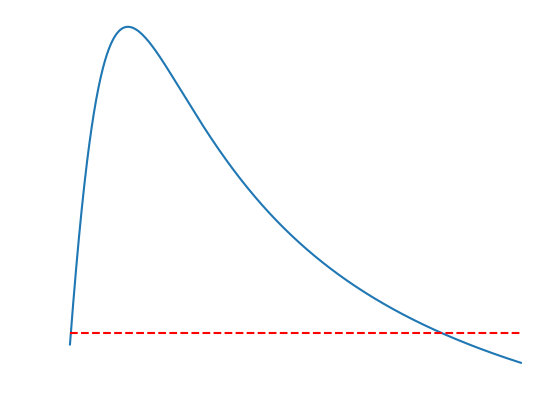

In [95]:
r = 0.39
f = lambda z: skyrmion.b_1(R=r, z=z)/(simulation_params['Bz'] + skyrmion.b_0(R=r, z=z))
f= lambda z: skyrmion.b_2(R=r, z=z)/skyrmion.b_1(R=r, z=z)

x = np.linspace(0.5, 3, 1000)
plt.plot(x, f(x))
plt.hlines((2*varphi - 1)/(2*np.sqrt(2)), 0.5, 3, color='red', linestyle='--')
#plt.hlines(np.sqrt(2), 0.5, 3, color='red', linestyle='--')

In [96]:
skyrmion.update_geometry(50, 50, 30)
qubit = Hamiltonian2D_Elliptical_Quantum_Well(lx, simulation_params['ly'], simulation_params['Bz'], skyrmion)

In [97]:
from tqdm import tqdm

R = np.linspace(10/lx, 50/lx, 100)
Delta_z = np.linspace(0.5, 3, 10)

r = 50
energies = []
Kp = []
b1 = []
b2 = []
Bt = []
for z in tqdm(Delta_z):
    skirmion = CylindricalMagnet(M, r, 50, z * lx)
    qubit = Hamiltonian2D_Elliptical_Quantum_Well(lx, simulation_params['ly'], simulation_params['Bz'], skirmion)
    kp = np.abs(qubit.omega_x / qubit.omega_c)
    Kp.append(kp)
    b1.append(skirmion.b_1())
    b2.append(skirmion.b_2())
    Bt.append(skirmion.b_0() + simulation_params['Bz'])
    energies.append(qubit.get_numeric_energies())

100%|██████████| 10/10 [00:02<00:00,  4.37it/s]


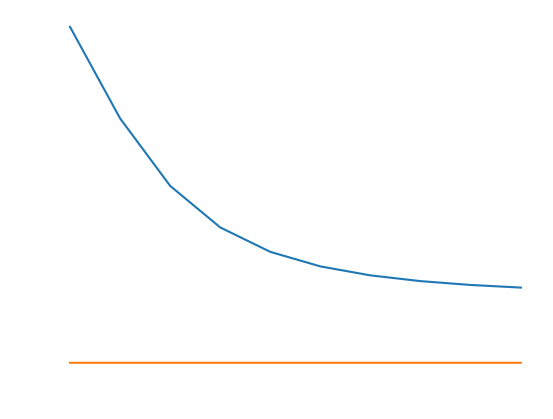

In [98]:
Kp = np.array(Kp)
b1 = np.array(b1)
b2 = np.array(b2)
Bt = np.array(Bt)
plt.plot(Delta_z, 1/Kp, label='Kp')
#plt.hlines((2*varphi - 1)/(2*np.sqrt(2)), 0.5, 3, color='red', linestyle='--')
#plt.plot(Delta_z, b1/Bt, label='b1')
plt.plot(Delta_z, b2, label='b2')

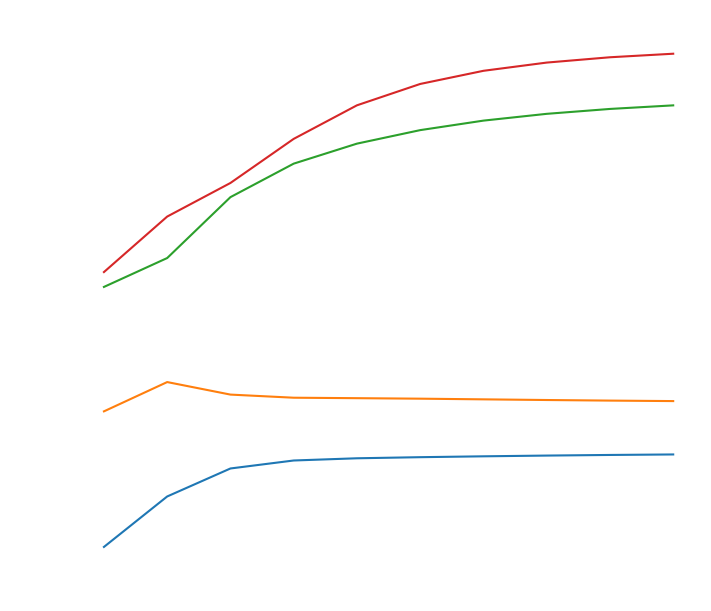

In [99]:
fig, ax = plt.subplots(figsize=(7, 6), constrained_layout=True)

energies = np.array(energies)
for i in range(4):
    ax.plot(Delta_z, energies[:, i], label=f'Level {i}')

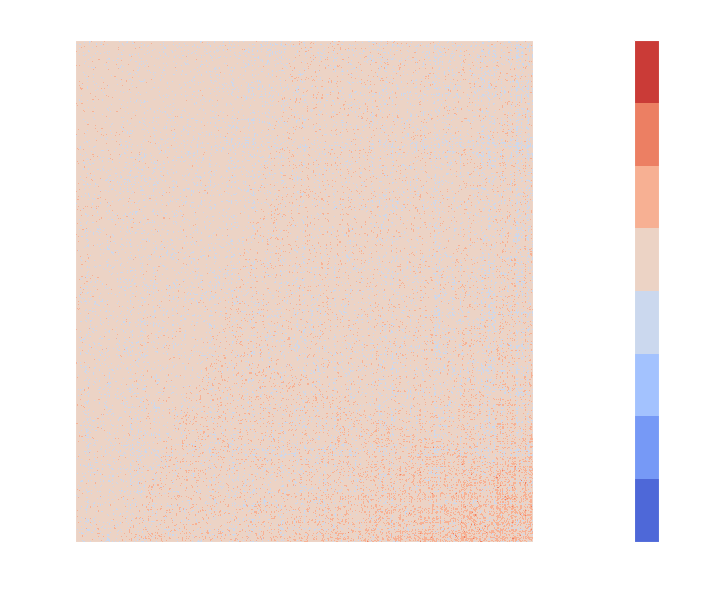

In [100]:
fig, ax = plt.subplots(figsize=(7, 6), constrained_layout=True)

KYs = np.linspace(1.01, 2, 1000)
KBs = np.linspace(1.01, 2, 1000)
KYS, KBS = np.meshgrid(KYs, KBs)

kp = k_p_val(KYS, KBS)
km = k_m_val(KYS, KBS)
Kp = K(kp)
Km = K(km)

B = (KYS**2 + 1)/KYS**2
f_to_compare = -2*(KYS - 1)*(kp - km)/(KYS**2 + kp**2 + km**2 + 1)

im = ax.contourf(KYS, KBS, (Kp - Km) - f_to_compare, cmap='coolwarm')

ax.set_xlabel(r'$k_y$', fontsize=18, color='white')
ax.set_ylabel(r'$k_B$', fontsize=18, color='white')
ax.set_title(r'$K_+ + K_-$', fontsize=18, color='white', pad=10)

fig.colorbar(im, ax=ax, orientation='vertical', pad=0.1)


C:\Users\reascoir\AppData\Local\Temp\ipykernel_3376\1340877976.py:11: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  res = fsolve(f, x_zero, xtol=tol)


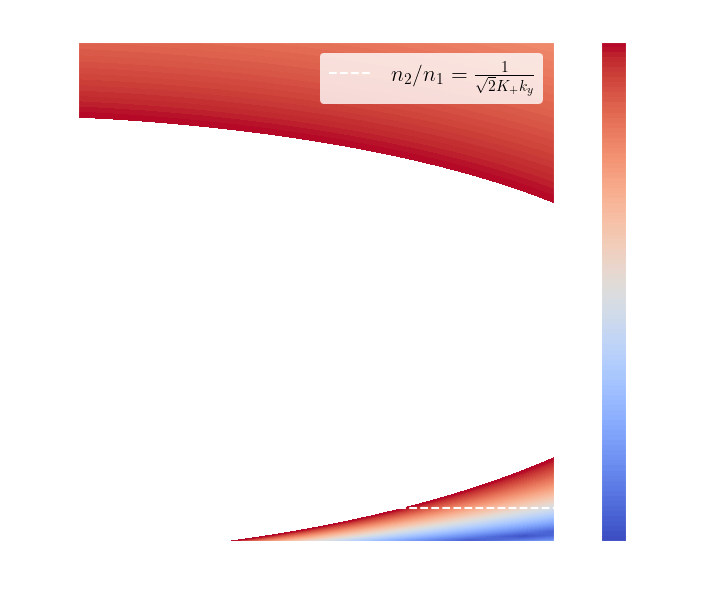

In [101]:
fig, ax = plt.subplots(figsize=(7, 6), constrained_layout=True)

Kb = 1.31
Kys = [1, 1.5, 2]
for i, ky in enumerate(Kys):
    line_less_equal_sqrt2 = []
    for r in R:
        Kp = K(k_p_val(ky, Kb))
        res =  found_zeros(lambda z: skyrmion.b_2(R=r, z=z)/skyrmion.b_1(R=r, z=z) - 1/(np.sqrt(2)*Kp*ky), 0.5, Delta_z.max(), N=1000, tol=1e-12)
        if len(res) == 1:
            line_less_equal_sqrt2.append([np.nan, res[0]])
        elif len(res) == 2:
            line_less_equal_sqrt2.append([res[0], res[1]])
        else:
            line_less_equal_sqrt2.append([np.nan, np.nan])

    line_less_equal_sqrt2 = np.array(line_less_equal_sqrt2)

    if ky == 1:
        ax.plot(R, line_less_equal_sqrt2[:,0], linestyle='--', label=r'$n_2/n_1 = \frac{1}{\sqrt{2}K_+ k_y}$', color='white')
        ax.plot(R, line_less_equal_sqrt2[:,1], linestyle='--', color='white')
    else:
        ax.plot(R, line_less_equal_sqrt2[:,0], linestyle='--', color='white')
        ax.plot(R, line_less_equal_sqrt2[:,1], linestyle='--', color='white')

vmax =  (2*varphi - 1)/(2*np.sqrt(2))
vmin = 0
N_levels = 100

levels = np.linspace(vmin, vmax, N_levels)


im = ax.contourf(R_mesh, Delta_z_mesh, B2 / B1, cmap='coolwarm', levels=levels, vmax=vmax, vmin=vmin)


ax.set_xlabel(r'$R/l_x$', fontsize=18, color='white')
ax.set_ylabel(r'$\Delta z/l_x$', fontsize=18, color='white')
ax.set_title(r'$n_1/n_2$', fontsize=18, color='white', pad=10)

fig.colorbar(im, ax=ax, orientation='vertical', pad=0.1)

ax.legend()